<h1>Prevendo o Nível de Satisfação de Clientes Santander</h1>
<b>Éverton Bin</b><br>
<b>Julho, 2020</b>

<h2>Índice</h2>
<ol>
    <a href = '#intro'><li><b>Introdução</b></li></a>
    <a href = '#carrega'><li><b>Carregando os Dados</b></li></a>
    <a href = '#analise'><li><b>Análise Descritiva</b></li></a>
    <a href = '#preproc'><li><b>Pré-Processamento de Dados</b></a>
        <ol>
            <a href = '#exclusion'><li><b>Exclusão de Variáveis Neutras</b></li></a>
            <a href = '#normal'><li><b>Normalização dos Dados</b></li></a>
            <a href = '#pca'><li><b>Redução de Dimensionalidade - PCA</b></li></a>
            <a href = '#smote'><li><b>Balanceamento dos Dados - SMOTE</b></li></a>
        </ol>
    <a href = '#predmodel'><li><b>Modelo Preditivo</b></li></a>
        <ol>
            <a href = '#createmod'><li><b>Criando e Treinando o Modelo Preditivo</b></li></a>
            <a href = '#evalmodel'><li><b>Avaliando o Modelo Preditivo</b></li></a>
        </ol>
    <a href = '#conclusao'><li><b>Conclusão</b></li></a>
</ol>

<h2>1- Introdução</h2>
<p>
    Identificar, desde o início, se um cliente está ou não satisfeito com a relação com uma empresa pode permitir que esta empresa promova medidas proativas que melhorem a satisfação do cliente antes que ele a abandone. O Santander, ao promover uma competição Kaggle com o objetivo de possibilitar esta identificação antecipada, acredita que clientes insatisfeitos costumam trocar de banco e raramente verbalizam esta insatisfação antes de fazer a troca.  
</p>
<p>
    Este projeto tem como objetivo criar um modelo preditivo capaz de prever a satisfação dos clientes do Banco Santander, fazendo uso de dados disponibilizados na plataforma do Kaggle, dados estes que podem ser acessados <a href = "https://www.kaggle.com/c/santander-customer-satisfaction">aqui</a>.
</p>
<p>
    O arquivo de referência para este estudo apresenta 370 variáveis preditoras (<i>features</i>) e uma variável-alvo que indica <b>0</b> para cliente satisfeito e <b>1</b> para cliente insatisfeito. Infelizmente, o dicionário de dados não foi fornecido, tornando as variáveis preditoras anônimas e, portanto, impedindo que possamos entender exatamente qual é a informação que cada variável representa. Por isso, não será feita uma análise de dados mais aprofundada que possibilitaria extrair informações e insights dos dados fornecidos.
</p>

<h2>2- Carregando os Dados</h2>

In [1]:
# Pacotes utilizados:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from xgboost import XGBClassifier

In [2]:
# Leitura do arquivo:
cust_sat = pd.read_csv('train.csv')

In [3]:
cust_sat.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<h2>3- Análise Descritiva</h2>
<p>
    Faremos apenas uma análise descritiva dos dados, observando valores mínimos, máximos, média, possíveis outliers e as suas relações com a variável target. Como mencionado anteriormente, uma análise exploratória dos dados só seria possível caso tivéssemos mais informações sobre o que os dados numéricos disponibilizados representam.
</p>
<p>
    Primeiramente, vamos verificar se existe equilíbrio entre as observações de classes de clientes satisfeitos e insatisfeitos (0 e 1), pois, em não havendo equilíbrio, torna-se necessário fazer o balanceamento das classes para evitar que o modelo aprenda muito sobre uma das categorias e pouco sobre a outra.
</p>

In [4]:
# Contabilizando os dados por classe:
cust_sat[['ID', 'TARGET']].groupby(['TARGET']).count()

,ID
TARGET,
0,73012
1,3008


<p>
    É possível observar que as classes estão desbalanceadas, tornando necessária a aplicação de alguma técnica estatística que equilibre as duas classes, evitando problemas no modelo que será criado. Neste caso, faremos uso da técnica <b>SMOTE</b> que será executada antes do treinamento do modelo preditivo.
</p>
<p>
    A partir de agora, vamos fazer observar as estatísticas por variável (número de observações, média, desvio padrão, mínimo, máximo e quartis). Como este problema envolve um grande número de variáveis, vamos destacar alguns subconjuntos que podem representar a variabilidade observada nos dados.
</p>

In [5]:
cust_sat.iloc[:, 0:7].describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000


In [6]:
cust_sat.iloc[:, 90:100].describe()

,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.00000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,2.894041,1.999171,0.000316,0.000079,0.09854,0.085793,0.211247,0.138003,0.167719,0.130308
std,0.656479,1.431902,0.030774,0.015388,0.53493,0.500022,0.890236,0.637259,0.745822,0.618826
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,15.000000,3.000000,3.000000,6.00000,3.000000,111.000000,15.000000,18.000000,6.000000


In [7]:
cust_sat.iloc[:, 171:181].describe()

,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28
count,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.0
mean,0.513023,6.487948e+03,69.096200,1.834059e+02,4.340963e+01,27.399456,5.925120e+03,76.081633,72.735693,0.0
std,113.597559,3.841675e+04,2839.618964,2.269813e+04,1.093497e+04,2477.810744,4.800853e+04,739.776626,726.882669,0.0
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0
25%,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0
50%,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0
75%,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0
max,30000.000000,1.500000e+06,450000.000000,6.119500e+06,3.000000e+06,455858.160000,3.008077e+06,69756.720000,69756.720000,0.0


In [8]:
cust_sat.iloc[:, 241:247].describe()

,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1
count,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.0,76020.000000
mean,8.541207e+02,1.932954e+03,1.874808,2.512678,0.0,1.913616
std,1.425589e+04,2.535572e+04,388.245022,508.968831,0.0,357.405330
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000
75%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000
max,1.155003e+06,2.310003e+06,96781.440000,133730.580000,0.0,69622.290000


In [9]:
cust_sat.iloc[:, 330:336].describe()

,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1
count,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,8.913659e+02,1077.256756,1048.856447,68.275452,9.505287,124.620962
std,9.888597e+03,9614.906985,8189.948852,1733.838226,519.389157,2205.249804
min,-8.040000e+00,-922.380000,-476.070000,-287.670000,0.000000,-3401.340000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.900000e-01,3.000000,2.730000,0.000000,0.000000,0.000000
75%,1.221750e+01,90.000000,83.790000,0.000000,0.000000,0.000000
max,1.542339e+06,601428.600000,544365.570000,231351.990000,77586.210000,228031.800000


In [10]:
cust_sat.iloc[:, 365:].describe()

,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


<p>
    Com exceção das colunas "ID" e "TARGET", cujos números representam, respectivamente, a chave de identificação do cliente e a categoria cliente satisfeito ou insatisfeito, as demais variáveis representam valores numéricos contínuos que apresentam uma grande variedade de magnitude entre elas (dezenas, centenas, milhares, etc.). Sendo assim, posteriormente faremos a <b>normalização</b> dos dados para que os mesmos sejam representados em uma mesma escala.
</p>
<p>
    Como passo seguinte, vamos utilizar faixas similares aos subsets acima para criarmos uma matriz de correlação entre as variáveis seleicionadas e também entre elas e a variável target. Desta forma, podemos observar o nível de importância de cada um dos atributos na classificação de satisfação dos clientes para, então, decidirmos de que maneira será feita a seleção das variáveis mais importantes. Para este passo, será criada uma função que gera a plotagem da matriz de correlação para o subset indicado.
</p>

In [11]:
# Criando uma função para geração da matriz de correlação:
def subset_corr(start_ind, final_ind, df = cust_sat):
    """ Cria um plot indicando a correlação entre as variáveis do subset e a variável target 
    
    Args:
    start_ind: número inteiro, iniciando em 1 - zero é a variável 'ID';
    final_ind: número inteiro, no máximo 370.
    """
    
    targ = df['TARGET']
    sub_df = df.iloc[:, start_ind:final_ind]
    sub_df = pd.concat([sub_df, targ], axis = 1)
    
    subset_corr = sub_df.corr()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 12))
    corr_plot = sns.heatmap(subset_corr, annot = True, fmt = '.3g', vmin = -1, vmax = 1, center = 0,
                            cmap = 'RdYlBu', square = True)
    ax.set_title('Matriz de Correlação entre Variáveis')
    
    fig.show()

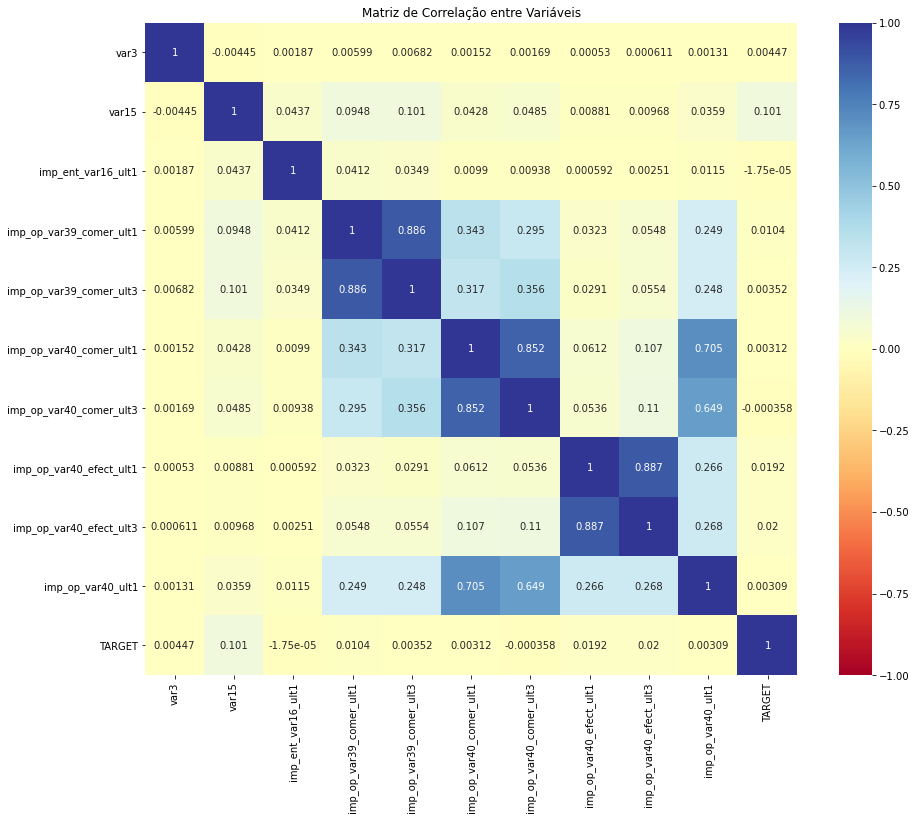

In [12]:
subset_corr(1, 11)

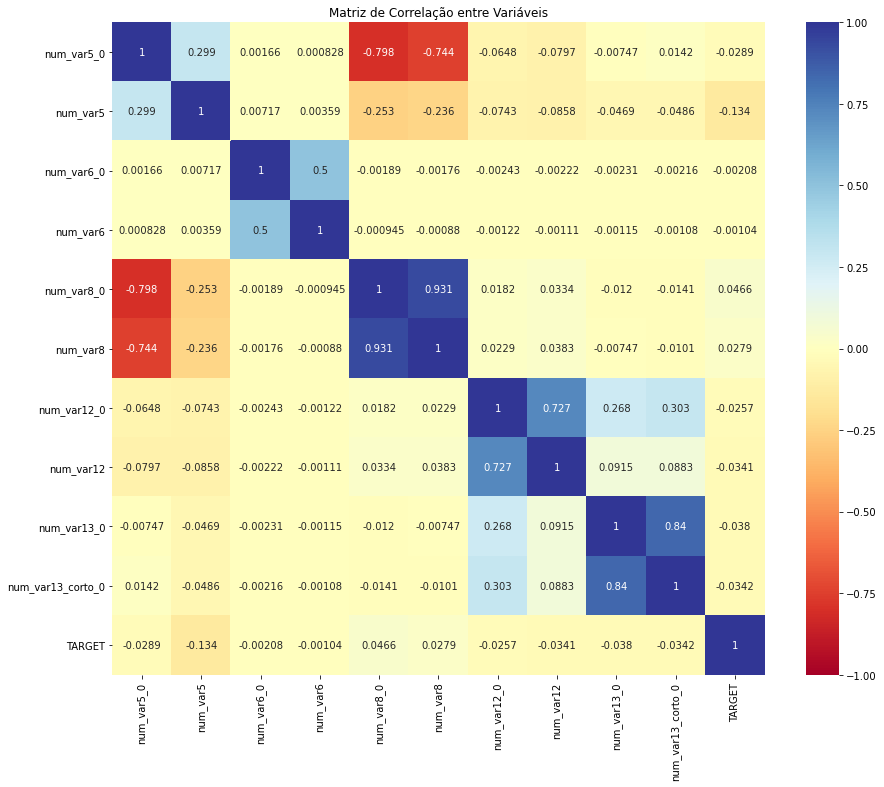

In [13]:
subset_corr(90, 100)

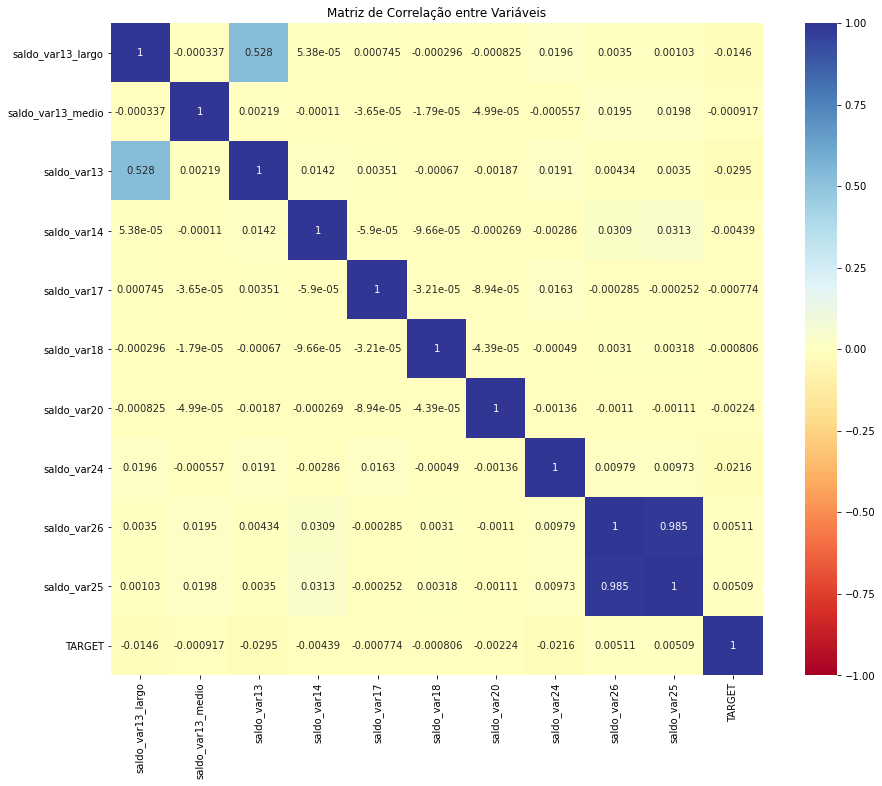

In [14]:
subset_corr(170, 180)

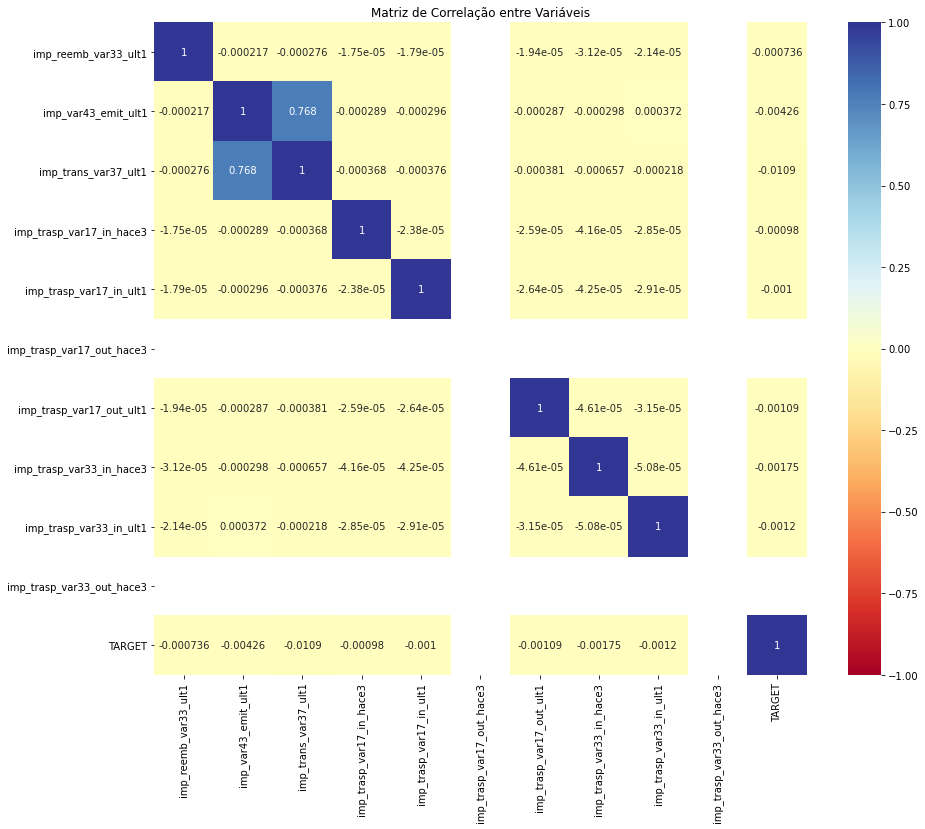

In [15]:
subset_corr(240, 250)

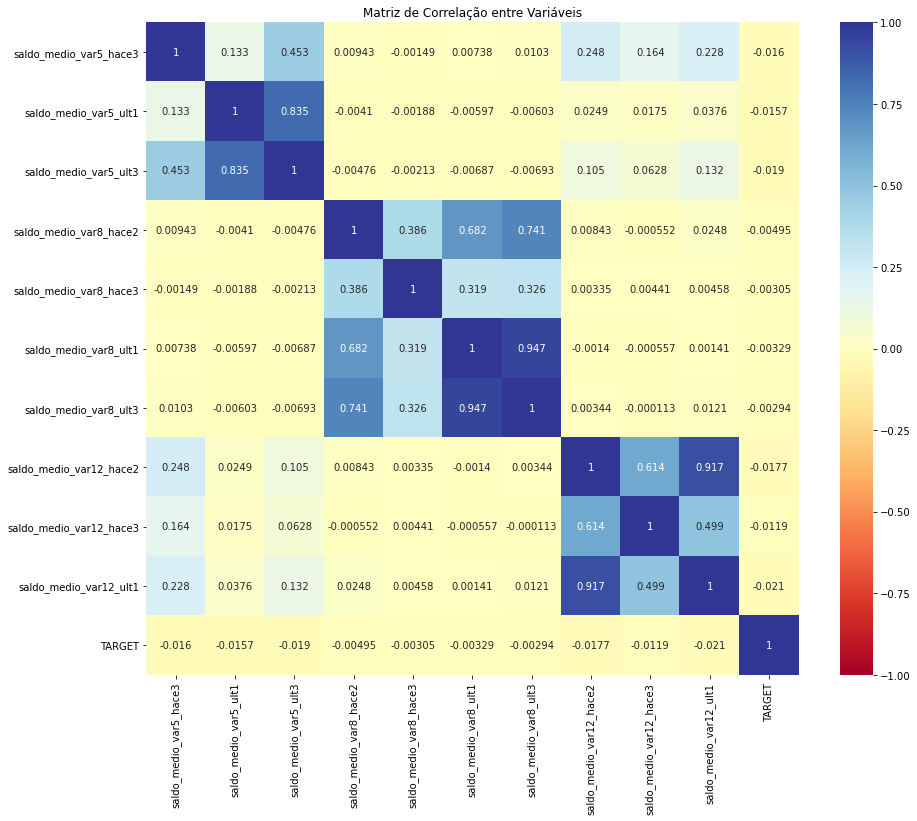

In [16]:
subset_corr(330, 340)

<p>
    De modo geral, apesar de os dados apresentados nas matrizes acima mostrarem valores muito distintos de correlação com a variável target, pode-se dizer que a grande maioria pertence a uma mesma escala, sendo difícil selecionar os que se destacam por uma correlação maior, seja ela positiva ou negativa.
</p>
<p>
    Também é possível encontrar muitas variáveis que apresentam forte correlação entre si, o que pode representar algum problema para o modelo, caso elas não sejam independentes entre si. Também podemos perceber variáveis, como o caso da <i>imp_trasp_var17_out_hace3</i>, que são representadas por valores <i>zero</i> em todos os registros.
</p>
<p>
    A partir destas observações, vamos excluir as variáveis cujos valores mínimo e máximo são iguais, sendo que todas as demais variáveis serão utilizadas no treinamento do modelo, ainda que, devido ao grande número de atributos, aplicaremos redução de dimensionalidade com <b>PCA</b>.

<h2>4- Pré-Processamento de Dados</h2>
<p>
    A partir deste momento, vamos fazer o tratamento dos dados, contemplando as questões observadas anteriormente na etapa de análise descritiva do conjunto de dados. Faremos a exclusão das variáveis que não influenciam nos resultados, colocaremos os dados em uma escala padrão para, posteriormente, aplicarmos a redução de dimensionalidade com maior efetividade e, então, balancearmos as classes para treinamento do modelo. 
</p>

<h3>4.1- Exclusão de Variáveis Neutras</h3>
<p>
    Pela análise descritiva dos dados, bem como pela avaliação das correlações, conseguimos identificar que o conjunto de dados possui variáveis que apresentam um único valor para todas as observações registradas. Com isso, podemos concluir que esta variável não é capaz de interferir na diferenciação das classes que queremos prever e, portanto, estas variáveis serão eliminadas do conjunto de dados, permitindo, assim, uma primeira redução no número de variáveis.     
</p>

In [17]:
# Criando um loop for para armazenar em lista os índices das colunas cujos valores mínimo e máximo são iguais:
ind_list = []

for i in range(len(cust_sat.columns)):
    if cust_sat.iloc[:, i].min() == cust_sat.iloc[:, i].max():
        ind_list.append(i)

# Excluindo as colunas correspondentes aos índices salvos em ind_list:
cust_sat = cust_sat.drop(cust_sat.iloc[:, ind_list], axis = 1)
cust_sat.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<p>
    Com este procedimento, o dataset original, que apresentava originalmente 371 colunas, agora apresenta 337 colunas, ou seja, 34 colunas foram excluídas nesta etapa.
</p>

<h3>4.2- Normalização dos Dados</h3>
<p>
    O grande número de variáveis disponibilizado apresenta também uma grande variedade de escalas numéricas, o que, para alguns algoritmos de aprendizado, pode representar um problema. Ainda que para alguns algoritmos é verdade que a escala dos dados não afeta o resultado, queremos aplicar, posteriormente, a redução de dimensionalidade (neste caso, através do algoritmo PCA), ou seja, queremos entregar ao modelo um número menor de variáveis. Com os dados padronizados, a definição dos componentes principais feita pelo PCA pode ser mais eficiente.    
</p>
<p>
    Antes de aplicarmos a normalização aos dados, vamos dividí-los em 'X' e 'Y' - variáveis independentes e variável dependente:
</p>

In [18]:
# Criando as variáveis 'X' e 'Y' a partir do conjunto de dados atual:
X = cust_sat.iloc[:, 1:-1]
Y = cust_sat.iloc[:, -1]

In [19]:
# Padronizando os dados com o MinMaxScaler():
scaler = MinMaxScaler(feature_range = (0,1))
X_norm = scaler.fit_transform(X)

<h3>4.3- Redução de Dimensionalidade - PCA</h3>
<p>
    Com os dados já padronizados, vamos reduzir as 335 variáveis preditoras restantes em 30 componentes principais, através da aplicação do algoritmo <i>Principal Component Analysis</i>:
</p>

In [20]:
pca = PCA(n_components = 30)
X_comp = pca.fit_transform(X_norm)

<h3>4.4- Balanceamento dos Dados - SMOTE</h3>
<p>
    Como visto anteriormente, as classes <b>0</b> e <b>1</b> estão desbalanceadas no conjunto de dados fornecido, o que significa dizer que temos muitas informações sobre os clientes satisfeitos e relativamente poucas informações sobre clientes insatisfeitos. Para amenizar este problema e evitar que o modelo aprenda muito mais sobre uma das classes, vamos utilizar a função <i>SMOTE</i>. 
</p>
<p>
    Apenas aplicaremos esta técnica aos dados que servirão para treinar o modelo e, por isso, antes de fazê-lo devemos fazer a divisão dos dados em dados de treino e dados de teste:

In [21]:
# Dividindo os dados em treino e teste:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X_comp, Y, test_size = 0.3, random_state = 101)

In [22]:
# Aplicando SMOTE aos dados de treino:
sm = SMOTE(random_state = 102)
X_treino_bal, Y_treino_bal = sm.fit_sample(X_treino, Y_treino)

<p>
    Finalizamos, assim, a etapa de pré-processamento de dados e estamos prontos para a criação do modelo preditivo.
</p>

<h2>5- Modelo Preditivo</h2>
<p>
    Nesta etapa, vamos fazer uso do algoritmo de aprendizado chamado <i>XGBoost</i>. Primeiramente, o modelo será criado para, então, alimentá-lo com os dados de treino. 
</p>
<p>
    Com o modelo treinado, será possível fazer as previsões a partir do conjunto de dados de teste para que, finalmente, possamos avaliar o desempenho do modelo na predição das classes desejadas. Para este estudo, desejamos uma acurácia mínima de <b>70%</b>.
</p>

<h3>5.1- Criando e Treinando o Modelo Preditivo</h3>
<p>
    Para efeito de estudo, não nos aprofundaremos nos diversos parâmetros do <i>XGBoost</i> que possibilitariam o ajuste fino no intuito de aprimorar o desempenho do modelo. Sendo assim, faremos a sua aplicação com os parâmetros <i>default</i> do próprio algoritmo:     
</p>

In [23]:
# Criando e treinando o modelo:
modelo = XGBClassifier()
modelo.fit(X_treino_bal, Y_treino_bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<p>
    Com o modelo treinado, podemos aplicar os dados teste para que o modelo faça as suas previsões:
</p>

In [24]:
# Fazendo as previsões:
Y_pred = modelo.predict(X_teste)

<h3>5.2- Avaliando o Modelo Preditivo</h3>
<p>
    Para fazermos a avaliação do modelo treinado, precisamos comparar as previsões feitas por ele nos dados de teste com os resultados reais do conjunto de dados. Neste estudo, a métrica de avaliação utilizada será a acurácia:  
</p>

In [25]:
# Calculando a acurácia do modelo:
accuracy = accuracy_score(Y_teste, Y_pred)
print('A acurácia do modelo de classificação XGBoost para os dados de teste é de', round(accuracy*100), '%.')

A acurácia do modelo de classificação XGBoost para os dados de teste é de 80.0 %.


<p>
    A acurácia de 80% é relativamente boa, maior do que o mínimo de 70% estabelecido. No entanto, para entendermos melhor o comportamento do modelo, vamos criar algumas matrizes de confusão que nos permitirão visualizar a eficácia do modelo para ambas as classes estudadas.
</p>

In [26]:
# Criando a primeira matriz de confusão:
confusion_matrix(Y_teste, Y_pred)

array([[17656,  4231],
       [  373,   546]], dtype=int64)

<p>
    Para que possamos visualizar a matriz de confusão de maneira mais amigável, utilizaremos a função <i>crosstab</i> do <i>Pandas</i> e, na seqüência, faremos uma plotagem da mesma através do <i>seaborn</i> que permite uma visualização ainda mais clara quanto à eficácia do modelo:
</p>

In [27]:
# Criando a matriz de confusão com Pandas:
pd.crosstab(Y_teste, Y_pred)

col_0,0,1
TARGET,,
0,17656,4231
1,373,546


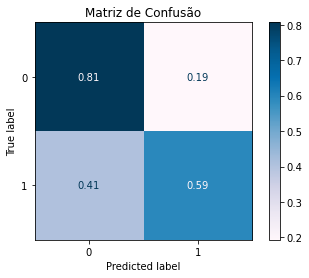

In [28]:
# Plotando a matriz de confusão 'normalizada' com o Seaborn:
class_names = [0, 1]
disp = plot_confusion_matrix(modelo, X_teste, Y_teste, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu,
                             normalize = 'true')
disp.ax_.set_title('Matriz de Confusão')
plt.show()

<h2>6- Conclusão</h2>
<p>
    Embora a acurácia do modelo criado tenha ficado em aproximadamente 80%, é possível observar na matriz de confusão que o modelo acertou 81% dos clientes que estão, de fato, satisfeitos. No entanto, quando o alvo são os clientes insatisfeitos, o modelo teve uma acurácia de apenas 59%.
</p>
<p>
    Fica claro que, embora tenhamos feito o balanceamento dos dados, o modelo ainda assim aprendeu mais sobre os clientes satisfeitos do que sobre os insatisfeitos. Além dos parâmetros do modelo que poderiam ser modificados na tentativa de melhorar o seu desempenho, outro possível fator de melhora seria uma avaliação mais aprofundada das variáveis, o que demandaria também uma explicação sobre o significado de cada uma delas.
</p>

<h3>Fim.</h3>